In [1]:
# to suppress indexing error resulting from [:,None]
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import bambi
import pymc3 as pm
import arviz as az
from PIL import Image

import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

import matplotlib.pyplot as plt
%matplotlib inline

# custom imports
from utils.stats import get, get_var, sem_p, center
from utils.plotting import despine, cm2inch
from utils.general import make_sure_path_exists

# Data I/O

In [2]:
# directories to data files
subject_data_dir = 'data/subject_files/'
summary_data_dir = 'data/summary_files/'
# directory of mixed effect model results
mfx_dir = 'results/posterior_traces/mixed_effects_models/'

# make sure output dir exists
make_sure_path_exists('figures/')
make_sure_path_exists(mfx_dir)

# choice set sizes
setsizes = np.array([9, 16, 25, 36])
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']

# load response data
data = []
for setsize in setsizes:
    df_setsize = pd.read_csv(summary_data_dir+'{}_data.csv'.format(setsize))
    df_setsize['setsize'] = setsize
    data.append(df_setsize) #df_setsize.drop('Unnamed: 0', axis=1))
data = pd.concat(data, sort=True)
data.head()

# subject IDs
subjects = np.sort(data.subject.unique())
n_subject = subjects.size

# load gaze data
gaze_data = []
for subject in subjects:
    for c in setsizes:
        tmp_data = pd.read_csv(subject_data_dir+'{}_{}_fixations.csv'.format(subject, c))
        tmp_data = tmp_data[[c for c in tmp_data.columns if not 'Unnamed:' in c]]
        gaze_data.append(tmp_data)
gaze_data = pd.concat(gaze_data, sort=True)

In [3]:
data.head()

,best_chosen,best_seen_chosen,choice,fixation_count,fixation_onset_0,fixation_onset_1,fixation_onset_10,fixation_onset_11,fixation_onset_12,fixation_onset_13,...,stimulus_34,stimulus_35,stimulus_4,stimulus_5,stimulus_6,stimulus_7,stimulus_8,stimulus_9,subject,trial
0,1.0,1.0,1,18.0,1662.0,1238.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr62.png,nr125.png,nr63.png,nr113.png,nr27.png,NaN,0,2
1,1.0,1.0,0,14.0,907.0,625.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr76.png,nr93.png,nr79.png,nr4.png,nr92.png,NaN,0,3
2,1.0,1.0,1,20.0,893.0,503.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr56.png,nr91.png,nr30.png,nr106.png,nr121.png,NaN,0,7
3,1.0,1.0,3,12.0,773.0,4625.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr21.png,nr85.png,nr2.png,nr58.png,nr7.png,NaN,0,9
4,1.0,1.0,4,22.0,786.0,1010.0,NaN,NaN,NaN,NaN,...,NaN,NaN,nr69.png,nr81.png,nr79.png,nr58.png,nr28.png,NaN,0,14


In [4]:
gaze_data.head()

,choice,dur,fixnum,is_first,is_last,is_last_to_choice,is_refixation,item,onset,refixnum,setsize,stimulus,subject,trial,value
0,1,552,1,1.0,0.0,1,0,4,76,0.0,9,nr62.png,0,2,0
1,1,188,2,0.0,0.0,1,0,3,678,0.0,9,nr48.png,0,2,0
2,1,260,3,0.0,0.0,1,0,7,922,0.0,9,nr113.png,0,2,0
3,1,348,4,0.0,0.0,1,0,1,1238,0.0,9,nr10.png,0,2,2
4,1,326,5,0.0,0.0,1,0,0,1662,0.0,9,nr91.png,0,2,0


## Insert additional item attributes

### "Size" 

In [5]:
def compute_item_sizes(stimulus_images, rgb_threshold=5):
    """Compute the fraction of an image that is not black
    (ie. the snack food item). This function assumes that 
    the image background is consistently black.
    
    Args:
        stimulus_images (array): paths to stimulus images 
            for which size is to be computed
        rgb_threshold (int): defines the maximum value of
            any rgb-index that is still counted as black;
            if rgb_threshold = 5 all rgb-indeces must be < 5
                 
    Returns:
        array containing sizes for each stimulus image
    """
    # compute sizes of items, relative to image size
    relative_item_sizes = dict()
    for stimulus_image in stimulus_images:

        # load image
        im = Image.open(stimulus_image)
        colors = im.getcolors(im.size[0]*im.size[1])
        num_pixels = float(im.size[0]*im.size[1])
        # count black background pixels
        num_black_pixels = np.sum([s[0] for s in colors
                                   if np.all(np.array(s[1][:-1]) < rgb_threshold)])
        # determine size as % of image
        fraction_item = 1. - (num_black_pixels/num_pixels)
        relative_item_sizes[stimulus_image] = fraction_item

    return relative_item_sizes

In [6]:
# load image paths
image_dir = 'data/stimuli/'
stimulus_images = np.sort([image_dir+s for s in os.listdir(image_dir)
                           if s.endswith('.png')])

# compute image sizes
item_sizes = compute_item_sizes(stimulus_images)

# add sizes to data
trial_stimuli = data[['stimulus_{}'.format(i)
                      for i in range(np.max(setsizes))]].values
trial_stimulus_sizes = np.array([item_sizes[image_dir+stimulus]
                                 if str(stimulus) != 'nan' else np.nan
                                 for stimulus in trial_stimuli.ravel()])
trial_stimulus_sizes = trial_stimulus_sizes.reshape(trial_stimuli.shape)
for i in range(np.max(setsizes)):
    data['item_size_{}'.format(i)] = trial_stimulus_sizes[:,i]

### "Row" and "column" positions

In [7]:
def return_row_col_pairs(setsize):
    out = []
    for row in range(np.int(np.sqrt(setsize))):
        for col in range(np.int(np.sqrt(setsize))):
            out.append((row+1, col+1)) # we start indexing at 1
    return out      

In [8]:
from itertools import combinations_with_replacement
position_mapping = dict()
for setsize in setsizes:
    position_mapping[setsize] = return_row_col_pairs(setsize)
print(position_mapping)

{9: [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)], 16: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)], 25: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)], 36: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]}


In [9]:
for setsize in setsizes:
    for i in range(setsize):
        data.loc[data['setsize']==setsize, 'item_row_{}'.format(i)] = position_mapping[setsize][i][0]
        data.loc[data['setsize']==setsize, 'item_column_{}'.format(i)] = position_mapping[setsize][i][1]

# Create Figure 3

In [10]:
def aggregate_time_gaze_data(data, gaze_data):
    """ Aggregate gaze data for each normalized 
    time bin (0-100%).
    
    Args:
        data (dataframe): choice data
        gaze_data (dataframe): gaze data
            
    Returns:
        dataframe     
    """
    
    setsizes = np.sort(data.setsize.unique())
    subjects = np.sort(data.subject.unique())
    
    time_gaze_data = pd.DataFrame()
    # iterate setsizes
    for setsize in setsizes:
        # subset
        setsize_data = data[data['setsize']==setsize].copy()
        setsize_gaze_data = gaze_data[gaze_data['setsize']==setsize].copy()

        # iterate subjects
        for subject in subjects:
            # subset
            subject_data = setsize_data[setsize_data['subject']==subject].copy()
            subject_gaze_data = setsize_gaze_data[setsize_gaze_data['subject']==subject].copy()

            # initiate containers
            is_fixated = []
            size = []
            row = []
            column = []
            rating = []
            trial_time = []
            ms_trial_time = []
            is_refixation = []
            duration = []
            fixnum = []
            is_last = []
            trials = []
            # iterate trials
            for trial in subject_gaze_data.trial.unique():
                
                # subset
                trial_gaze_data = subject_gaze_data[subject_gaze_data['trial']== trial].copy()
                trial_fixation_positions = trial_gaze_data['item'].values.astype('int32')
                trials.append((np.ones((trial_fixation_positions.size, setsize)) * trial).ravel())
                trial_data = subject_data[subject_data['trial']==trial].copy()
                
                # extract & center item attributes
                trial_size = center(get(trial_data, 'item_size')[0][:setsize])
                trial_row = center(get(trial_data, 'item_row')[0][:setsize])
                trial_column = center(get(trial_data, 'item_column')[0][:setsize])
                trial_ratings = center(get(trial_data, 'item_value')[0][:setsize])

                # expand attributes for each fixation
                trial_is_fixated = np.zeros((trial_fixation_positions.size, setsize))
                trial_is_fixated[np.arange(trial_is_fixated.shape[0]), trial_fixation_positions] = 1
                is_fixated.append(trial_is_fixated.ravel())

                size_tmp = np.ones((trial_fixation_positions.size, setsize)) * trial_size[None]
                size.append(size_tmp.ravel())

                row_tmp = np.ones_like(size_tmp) * trial_row[None]
                row.append(row_tmp.ravel())

                column_tmp = np.ones_like(size_tmp) * trial_column[None]
                column.append(column_tmp.ravel())

                rating_tmp = np.ones_like(size_tmp) * trial_ratings[None]
                rating.append(rating_tmp.ravel())

                is_refixation_tmp = np.zeros_like(size_tmp)
                is_refixation_tmp[np.arange(is_refixation_tmp.shape[0]),
                                  trial_fixation_positions] = trial_gaze_data['is_refixation'].values
                is_refixation.append(is_refixation_tmp.ravel())

                duration_tmp = np.ones_like(size_tmp) * np.asarray(trial_gaze_data['dur'].values)[:, None]
                duration.append(duration_tmp.ravel())

                trial_time_normed = np.cumsum(trial_gaze_data['dur']) / np.sum(trial_gaze_data['dur'])
                trial_time_tmp = np.ones_like(size_tmp) * trial_time_normed[:, None]
                trial_time.append(trial_time_tmp.ravel())
                
                ms_trial_time_tmp = np.ones_like(size_tmp) * np.cumsum(trial_gaze_data['dur'])[:, None]
                ms_trial_time.append(ms_trial_time_tmp.ravel())
                
                fixnum_tmp = np.ones((trial_fixation_positions.size, setsize)) *\
                np.arange(1,len(trial_fixation_positions)+1)[:, None]
                fixnum.append(fixnum_tmp.ravel())
                
                is_last_tmp = np.zeros((trial_fixation_positions.size, setsize))
                is_last_tmp[-1] = 1
                is_last.append(is_last_tmp.ravel())

            # make dataframe
            time_gaze_data_tmp = pd.DataFrame()
            time_gaze_data_tmp['is_fixated'] = np.concatenate(is_fixated)
            # round size for numerical stability
            time_gaze_data_tmp['size'] = np.round(np.concatenate(size) * 100, 4)
            time_gaze_data_tmp['row'] = np.concatenate(row)
            time_gaze_data_tmp['column'] = np.concatenate(column)
            time_gaze_data_tmp['rating'] = np.concatenate(rating)
            time_gaze_data_tmp['is_refixation'] = np.concatenate(is_refixation)
            time_gaze_data_tmp['duration'] = np.concatenate(duration)
            # bin trial-time in 10 % bins
            time_gaze_data_tmp['normed_time_binned'] = np.round(
                (np.concatenate(trial_time) * 100) / 10.) * 10
            time_gaze_data_tmp['normed_time'] = np.concatenate(trial_time) * 100
            time_gaze_data_tmp['ms_time'] = np.concatenate(ms_trial_time)
            time_gaze_data_tmp['fixnum'] = np.concatenate(fixnum)
            time_gaze_data_tmp['is_last'] = np.concatenate(is_last)
            time_gaze_data_tmp['trial'] = np.concatenate(trials)
            time_gaze_data_tmp['subject'] = subject
            time_gaze_data_tmp['setsize'] = setsize
            
            # collect
            time_gaze_data = time_gaze_data.append(time_gaze_data_tmp[['setsize',
                                                                       'subject',
                                                                       'trial',
                                                                       'is_fixated',
                                                                       'size',
                                                                       'row',
                                                                       'column',
                                                                       'rating',
                                                                       'is_refixation',
                                                                       'duration',
                                                                       'ms_time',
                                                                       'normed_time',
                                                                       'normed_time_binned',
                                                                       'fixnum',
                                                                       'is_last']])
            
    return time_gaze_data

In [11]:
def figure_3(data,
             gaze_data,
             mfx_dir=mfx_dir+'',
             colors=['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral'],
             axs=None,
             ylims=None,
             verbose=False,
             seed=1):
    """ Create figure 3 of the manuscript.
    
    Args:
        data (dataframe): choice data
        gaze_data (dataframe): gaze data   
        mfx_dir (string): mixed effects posterior trace directory
        colors (array of strings): colors to use for choice set sizes
        axs (matpltolib axis object): axis to plot onto  
        ylims (tuple of tuples): y-lims for each axis;
            must have as many entries asaxs contained in figure
        verbose (bool): whether to print mixed effect estimates to terminal
        seed (int): random seed
            
    Returns:
        matplotlib figure / axes
    """
    
    # extract setsizes/subjects
    setsizes = data.setsize.unique()
    subjects = data.subject.unique()
    
    # aggregate time-gaze-data
    time_gaze_data = aggregate_time_gaze_data(data, gaze_data)
    
    # set time bins
    time_bins = np.arange(0,105,10)
   
    # Estimate mfx model for each time bin
    n_samples = 2000
    burn = 500
    mfx_coeffs = np.zeros((time_bins.size, 6, 3))
    for ti, time_bin in enumerate(time_bins):
        
        if verbose:
            print('\nTime bin: {}'.format(time_bin))
        
        mfx_filename = 'p-item-fixated_time-bin-{}_mfx'.format(time_bin)
        if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
            
            # make model
            time_bin_gaze_data = time_gaze_data[time_gaze_data['normed_time_binned']==
                                                time_bin].copy()
            model = bambi.Model(data=time_bin_gaze_data.copy())
            # add fixed effects
            model.add('is_fixated ~ row + column + rating + size + setsize',
                      categorical=['subject'])
            # add random effects
            model.add(random=['1|subject'])
            model.add(random=['0 + row|subject'])
            model.add(random=['0 + column|subject'])
            model.add(random=['0 + size|subject'])
            model.add(random=['0 + setsize|subject'])
            
            # sample posterior
            results = model.fit(samples=n_samples,
                                tune=burn,
                                chains=2,
                                family='bernoulli',
                                backend='pymc',
                                init='ADVI',
                                n_init=50000,
                                random_seed=seed+ti)
            
            # save results
            pm.trace_to_dataframe(model.backend.trace).to_csv(
                mfx_dir+mfx_filename+'_mtrace.csv', index=False)
            az.plot_trace(results)
            plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
            summary = az.summary(results, round_to='none')
            summary.to_csv(mfx_dir+mfx_filename+'.csv')

        else:   
            if verbose:
                print('Loading pre-computed posterior trace from: '+mfx_dir)
            summary = pd.read_csv(mfx_dir+mfx_filename+'.csv'.format(time_bin), index_col='Unnamed: 0')
        
        # collect coefficients
        for vi, var in enumerate(['row', 'column', 'rating', 'size', 'setsize']):
            var_mean, var_hpd = get_var(summary, var+'[0]', verbose=verbose)
            mfx_coeffs[ti,vi, 0] = var_mean
            mfx_coeffs[ti,vi, 1:] = var_hpd
        
    
    # Create figure
    tighten_layout = False
    if axs is None:
        tighten_layout = True
        fig, axs = plt.subplots(2,3, figsize=cm2inch(20,12), sharex=True, dpi=300)
        axs = axs.ravel()
    
    # plot fixed effects
    for fi, feature in enumerate(['row', 
                                  'column', 
                                  'rating', 
                                  'size']):
        # label
        axs[fi].set_ylabel(r'$\beta$'+'('+'{}'.format(feature)+')', fontsize=8)
        
        # get means & HPD
        means = mfx_coeffs[:,fi,0]
        hpds = mfx_coeffs[:,fi,1:]
        
        # plot
        axs[fi].plot(time_bins,
                     means,
                     lw=2,
                     color='black')
        axs[fi].fill_between(time_bins,
                             hpds[:,0],
                             hpds[:,1],
                             alpha=.2,
                             color='black')
        # plotting settings
        if ylims is not None:
            axs[fi].set_ylim(ylims[fi][0], ylims[fi][1])
        
        
    # also plot P(refixation)
    axs[-2].set_ylabel('P(returning gaze)'.format(feature), fontsize=8)
    # exclude first and last 
    middle_time_gaze_data = time_gaze_data[
        np.logical_and(time_gaze_data['fixnum']>1,
                       time_gaze_data['is_last']==0)].copy()
    # reduce to actual fixations
    middle_time_gaze_data = middle_time_gaze_data[
        middle_time_gaze_data['is_fixated']==1].copy()
    # compute means
    means = middle_time_gaze_data.groupby(
        ['setsize',  'subject',  'trial', 'normed_time_binned'])['is_refixation'].mean().groupby(
        ['setsize', 'subject', 'normed_time_binned']).mean().groupby(
        ['setsize', 'normed_time_binned']).mean()
    # compute sems
    sems = np.sqrt((means*(1-means))/means.size)
    # plot
    for si, setsize in enumerate(setsizes):
        axs[-2].plot(time_bins,
                     means[setsize],
                     label=setsize,
                     lw=2,
                     color=colors[si])
        axs[-2].fill_between(time_bins,
                             means[setsize]+sems[setsize],
                             means[setsize]-sems[setsize],
                             alpha=.2,
                             color=colors[si])
    axs[-2].axhline(0, ls='--', c='k', lw=.5)
    axs[-2].set_ylim(ylims[-2][0], ylims[-2][1])
    axs[-2].legend(loc='upper left', fontsize=7)
    
    
    # alos plot dur(returning gaze)
    axs[-1].set_ylabel('Mean duration of\nreturning gaze (ms)'.format(feature), fontsize=8)
    # exclude initial gazes to an item
    refix_time_gaze_data = middle_time_gaze_data[middle_time_gaze_data['is_refixation']== 1].copy()
    # compute means
    means = refix_time_gaze_data.groupby(
        ['setsize',  'subject',  'trial', 'normed_time_binned'])['duration'].mean().groupby(
        ['setsize', 'subject', 'normed_time_binned']).mean().groupby(
        ['setsize', 'normed_time_binned']).mean()
    # compute sems
    sems = refix_time_gaze_data.groupby(
        ['setsize', 'subject', 'trial', 'normed_time_binned'])['duration'].mean().groupby(
        ['setsize',  'subject', 'normed_time_binned']).mean().groupby(
        ['setsize', 'normed_time_binned']).sem()
    # plot
    for si, setsize in enumerate(setsizes):
        axs[-1].plot(time_bins,
                     means[setsize],
                     label=setsize,
                     lw=2,
                     color=colors[si])
        axs[-1].fill_between(time_bins,
                             means[setsize]+sems[setsize],
                             means[setsize]-sems[setsize],
                             alpha=.2,
                             color=colors[si])
    axs[-1].set_ylim(ylims[-1][0], ylims[-1][1])
            
         
    # label axes
    for ax in axs.ravel():
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_xlabel('Normalized time (%)', fontsize=8)
        ax.set_xticks([0, 50, 100]) 
        ax.set_xticklabels([0, 50, 100])
        despine(ax)
    
    for ax in axs.ravel()[:4]:
        ax.axhline(0, ls='--', color='k', lw=0.5)
    
    # index axes
    for label, ax in zip(list('ABCDEF'), axs):
        ax.text(-0.2, 1.15, label, transform=ax.transAxes, 
                fontsize=10, fontweight='bold', va='top')
    
    if tighten_layout:
        fig.tight_layout()
    
    return fig, axs


Time bin: 0
Loading pre-computed posterior trace from: results/posterior_traces/mixed_effects_models/
row[0]; Mean: -0.004988001358930796, 94% HPD: -0.0066768448509653385, -0.003347707903927557
column[0]; Mean: -0.004009610670243591, 94% HPD: -0.0053181935772277505, -0.002661447821372813
rating[0]; Mean: 0.00014134596514925622, 94% HPD: -0.0005941431269218639, 0.000904317521456986
size[0]; Mean: 7.873920478250282e-05, 94% HPD: -3.7421717092709824e-05, 0.00020761379308842853
setsize[0]; Mean: -0.001953812217450377, 94% HPD: -0.002102630125248803, -0.00181263815393347

Time bin: 10
Loading pre-computed posterior trace from: results/posterior_traces/mixed_effects_models/
row[0]; Mean: -0.010432947686681257, 94% HPD: -0.013393196202126423, -0.00781561252306146
column[0]; Mean: -0.0043977170157482, 94% HPD: -0.0059714794111385815, -0.0028105080739713475
rating[0]; Mean: 0.0006194598216239493, 94% HPD: 0.00022405763845233012, 0.0010296110925966944
size[0]; Mean: 0.00016865644996829322, 94% 

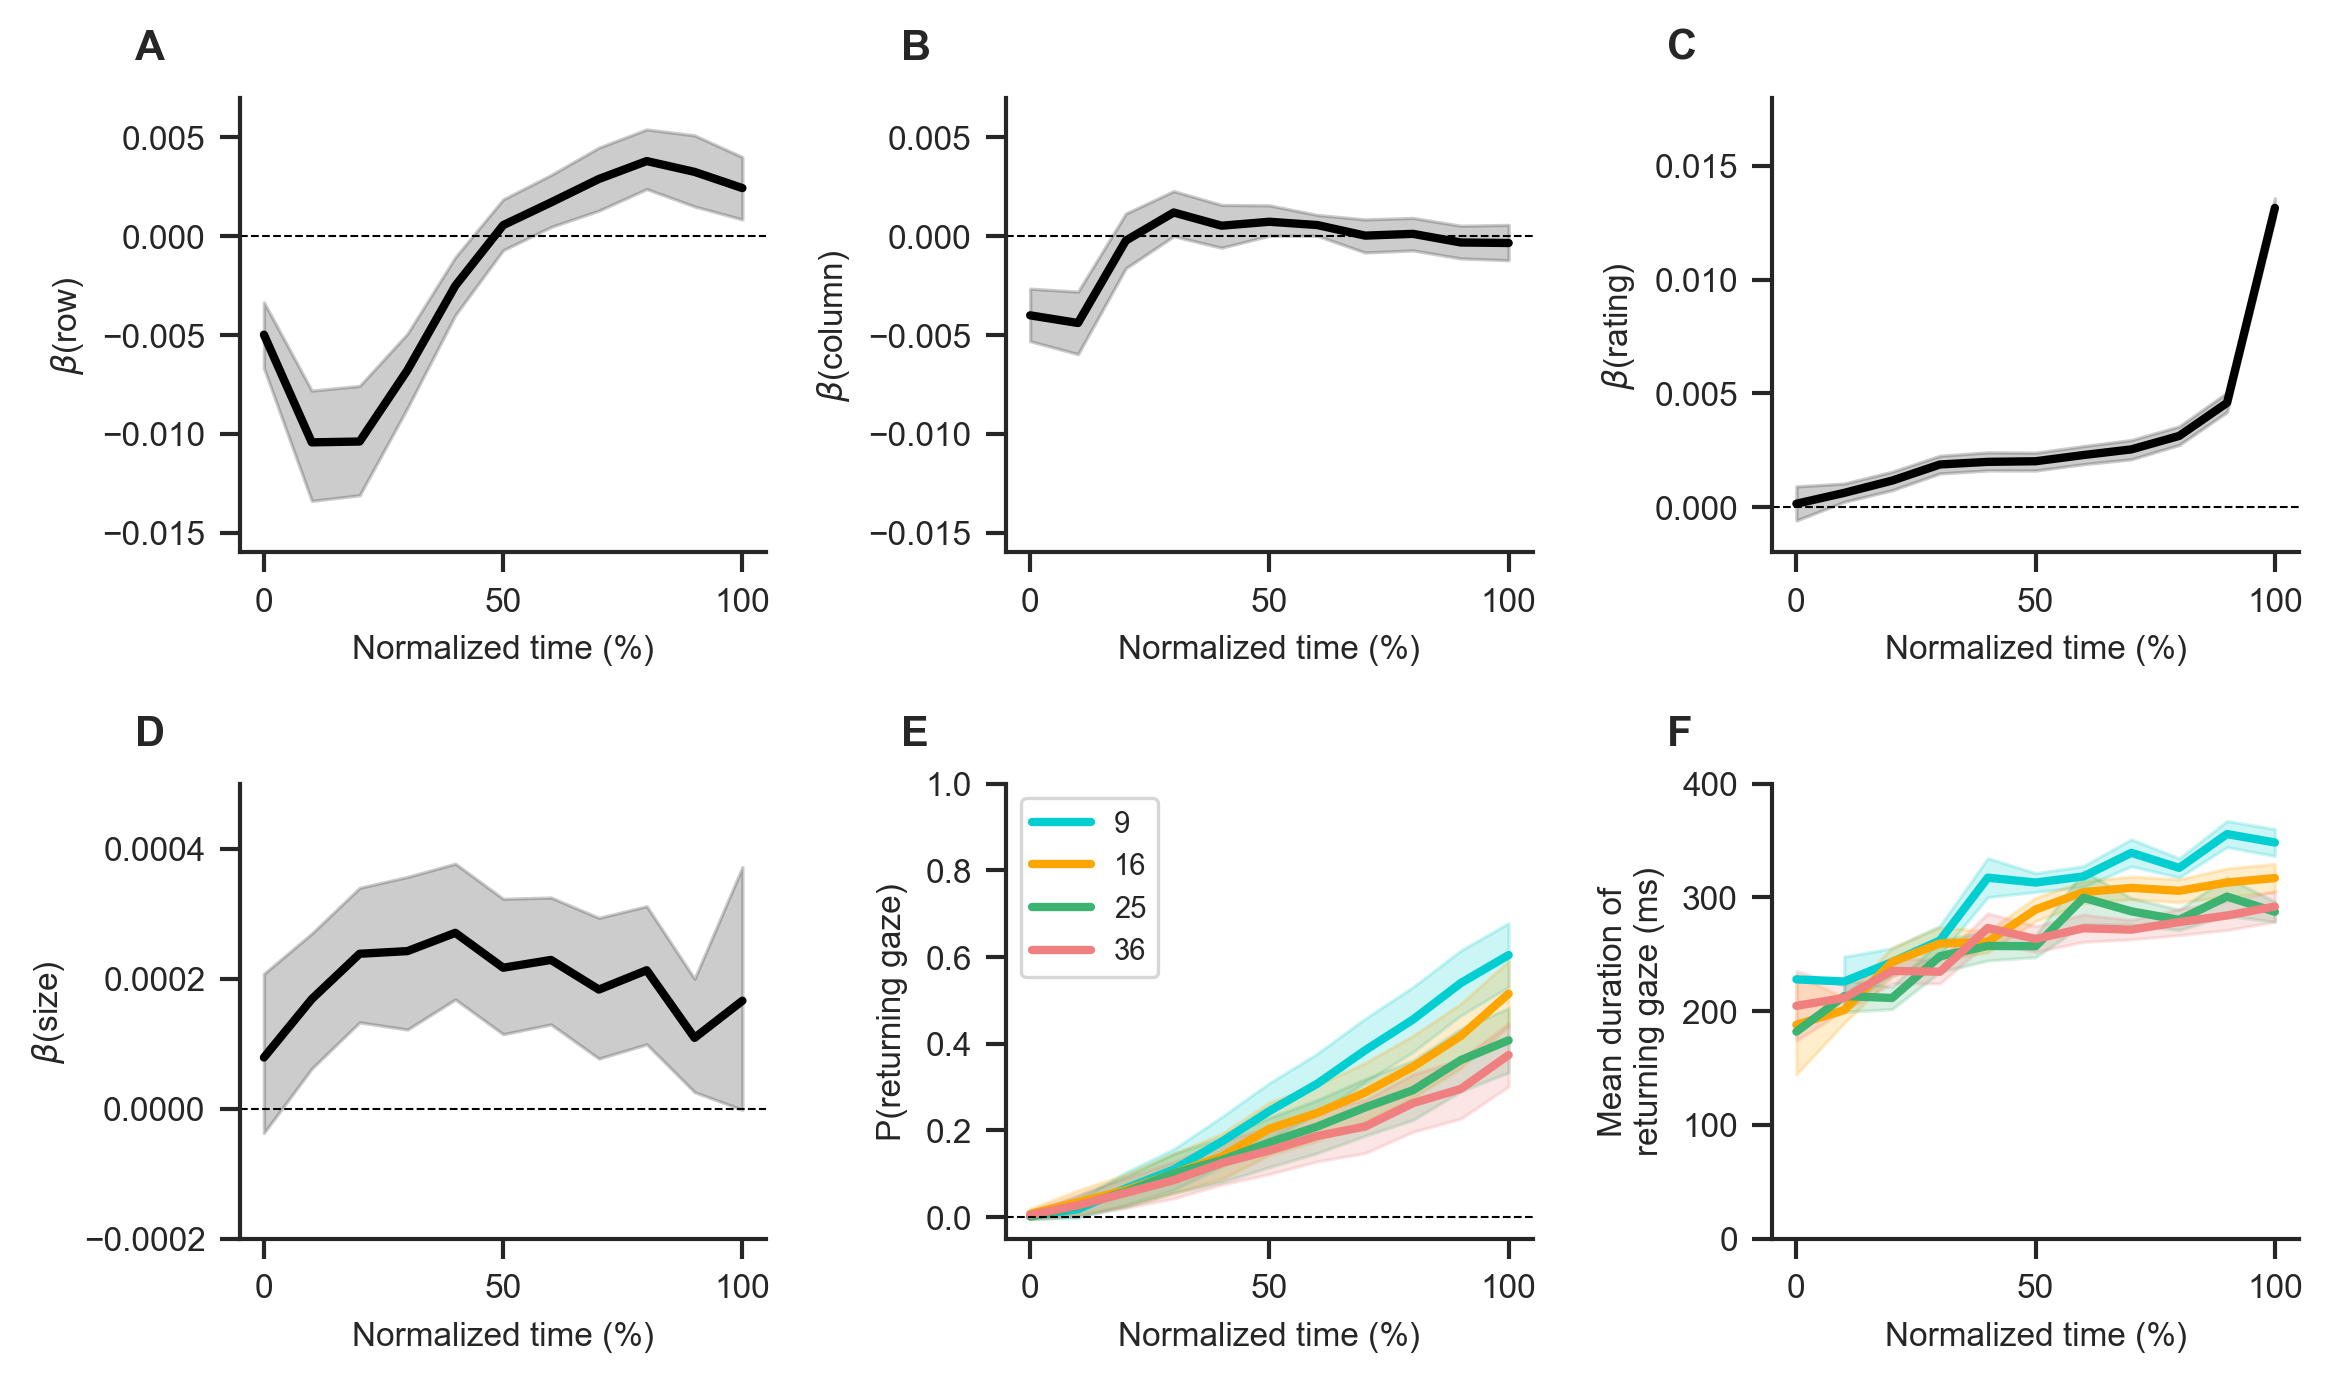

In [12]:
np.random.seed(62423)
f, _ = figure_3(data, gaze_data,
                ylims=[(-0.016, 0.007),
                       (-0.016, 0.007),
                       (-0.002, 0.018),
                       (-0.0002, 0.0005),
                       (-0.05, 1),
                       (0, 400)],
                seed=62423, verbose=True)
f.savefig('figures/Figure-3_visual-search-trajectories.pdf', dpi=300)
f.savefig('figures/Figure-3_visual-search-trajectories.jpg', dpi=300)
f.savefig('figures/Figure-3_visual-search-trajectories.png', dpi=300)

## $P(returning\_gaze) \sim time + setsize$

In [13]:
# load data
time_gaze_data = aggregate_time_gaze_data(data, gaze_data)
# exclude first and last trial gazes
time_gaze_data = time_gaze_data[np.logical_and(time_gaze_data['fixnum']>1,
                                               time_gaze_data['is_last']==0)].copy()
# reduce to data of current gaze
time_gaze_data = time_gaze_data[time_gaze_data['is_fixated']==1].copy()
time_gaze_data.head()

,setsize,subject,trial,is_fixated,size,row,column,rating,is_refixation,duration,ms_time,normed_time,normed_time_binned,fixnum,is_last
12,9,0,2.0,1.0,-9.1517,0.0,-1.0,-0.222222,0.0,188.0,740.0,11.301161,10.0,2.0,0.0
25,9,0,2.0,1.0,24.4906,1.0,0.0,-0.222222,0.0,260.0,1000.0,15.271839,20.0,3.0,0.0
28,9,0,2.0,1.0,0.3989,-1.0,0.0,1.777778,0.0,348.0,1348.0,20.586439,20.0,4.0,0.0
36,9,0,2.0,1.0,-18.2344,-1.0,-1.0,-0.222222,0.0,326.0,1674.0,25.565058,30.0,5.0,0.0
52,9,0,2.0,1.0,24.4906,1.0,0.0,-0.222222,1.0,790.0,2464.0,37.629811,40.0,6.0,0.0


In [14]:
np.random.seed(12399)
mfx_filename = 'p-refix_time_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
   
    # make model
    n_samples = 2000
    burn = 500
    model = bambi.Model(data=time_gaze_data.copy())
    # add fixed effects
    model.add('is_refixation ~ ms_time + setsize', categorical=['subject'])
    # add random effects
    model.add(random=['1|subject'])
    model.add(random=['0 + ms_time|subject'])
    model.add(random=['0 + setsize|subject'])
    
    # sample posterior
    results = model.fit(samples=n_samples,
                        tune=burn,
                        family='bernoulli',
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000, 
                        random_seed=12399)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print(
        'Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'ms_time[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.15419111767623686, 94% HPD: 0.1311215332838533, 0.17786647777864692
ms_time[0]; Mean: 9.926961692942084e-05, 94% HPD: 9.217846347394509e-05, 0.00010685408766288158
setsize[0]; Mean: -0.007287282785116236, 94% HPD: -0.007962021597598195, -0.00663027085390641


## $dur(returning\_gaze) \sim time + setsize$

In [15]:
refix_time_gaze_data = time_gaze_data[time_gaze_data['is_refixation']==1].copy()

In [16]:
np.random.seed(97203)
mfx_filename = 'dur-refix_time_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    n_samples = 2000
    burn = 500
    model = bambi.Model(data=refix_time_gaze_data.copy())
    # add fixed effects
    model.add('duration ~ ms_time + setsize', categorical=['subject'])
    # add random effects
    model.add(random=['1|subject'])
    model.add(random=['0 + ms_time|subject'])
    model.add(random=['0 + setsize|subject'])
    
    # sample posterior
    results = model.fit(samples=n_samples,
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000, 
                        random_seed=97203)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print(
        'Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract coefficient estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'ms_time[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 291.83460391783217, 94% HPD: 279.2248020560828, 303.89850847947423
ms_time[0]; Mean: 0.014279836158867276, 94% HPD: 0.011777420447825256, 0.01665995036041492
setsize[0]; Mean: -2.892932213882095, 94% HPD: -3.2666241367194924, -2.5131434253640488


## $P(chose\_item) \sim rating + row + column + size + setsize$

In [17]:
# collect data for mfx model
total_gaze_data = pd.DataFrame()
for setsize in setsizes:
    # subset
    setsize_data = data[data['setsize']==setsize].copy()
    
    for subject in subjects:
        # subset
        subject_data = setsize_data[setsize_data['subject']==subject].copy()
        
        # initiate containers
        size = []
        row = []
        column = []
        value = []
        gaze = []
        is_choice = []
        trials = []
        for trial in subject_data.trial.unique():
            
            # subset
            trial_data = subject_data[subject_data['trial']==trial].copy()
            
            # get & center item attributes
            trial_size = get(trial_data, 'item_size')[0][:setsize]
            trial_row = get(trial_data, 'item_row')[0][:setsize]
            trial_column = get(trial_data, 'item_column')[0][:setsize]
            trial_values = get(trial_data, 'item_value')[0][:setsize]
            trial_gazes = trial_data[['gaze_{}'.format(i) for i in range(setsize)]].values.ravel()            

            # collect
            size.append(trial_size)
            row.append(trial_row)
            column.append(trial_column)
            value.append(trial_values)
            gaze.append(trial_gazes)

            # label choice
            is_choice_tmp = np.zeros(setsize)
            is_choice_tmp[trial_data['choice'].values[0].astype(np.int)] = 1
            is_choice.append(is_choice_tmp)

            # collect
            trials.append(np.ones(setsize) *trial)

        # make dataframe
        subject_gaze_data = pd.DataFrame()
        # scale to 0 - 100
        subject_gaze_data['size'] = np.concatenate(size) * 100
        subject_gaze_data['row'] = np.concatenate(row)
        subject_gaze_data['column'] = np.concatenate(column)
        subject_gaze_data['value'] = np.concatenate(value)
        subject_gaze_data['is_choice'] = np.concatenate(is_choice)
        # scale to 0 - 100
        subject_gaze_data['gaze'] = np.concatenate(gaze) * 100
        subject_gaze_data['subject'] = subject
        subject_gaze_data['setsize'] = setsize
        subject_gaze_data['trial'] = np.concatenate(trials)

        # collect
        total_gaze_data = total_gaze_data.append(subject_gaze_data[['setsize',
                                                                    'subject',
                                                                    'trial',
                                                                    'size',
                                                                    'row',
                                                                    'column',
                                                                    'value',
                                                                    'gaze',
                                                                    'is_choice']])

In [18]:
np.random.seed(210380)
mfx_filename = 'p-choice_item-attributes_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):

    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=total_gaze_data.copy())
    # fixed effects
    model.add('is_choice ~ value + size + row + column + setsize', 
              categorical=['subject'])
    # random effects
    model.add(random=['1|subject'])
    model.add(random=['0+value|subject'])
    model.add(random=['0+size|subject'])
    model.add(random=['0+row|subject'])
    model.add(random=['0+column|subject'])
    model.add(random=['0+setsize|subject'])
    
    # sample posterior
    results = model.fit(samples=n_samples,
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000, 
                        family='bernoulli',
                        random_seed=210380)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')

else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0') 

# extract estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'value[0]')
_ = get_var(summary, 'size[0]')
_ = get_var(summary, 'row[0]')
_ = get_var(summary, 'column[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.09457416719924128, 94% HPD: 0.07700492655715015, 0.11191688155701884
value[0]; Mean: 0.03879853304278677, 94% HPD: 0.03528755843275692, 0.04258348915171745
size[0]; Mean: 0.0001965889167026525, 94% HPD: -0.00014566618703943157, 0.0005596922558468517
row[0]; Mean: -0.0005993886324904509, 94% HPD: -0.0012190625444521775, 0.00010534118526466588
column[0]; Mean: -0.0002846182350632643, 94% HPD: -0.0009152620764254027, 0.0003396667038585313
setsize[0]; Mean: -0.002419997133445248, 94% HPD: -0.002523029245180973, -0.002317467914869568


## $gaze \sim rating + row + column + size + setsize$

In [19]:
np.random.seed(71203)
mfx_filename = 'gaze_item-attributes_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    n_samples = 2000
    burn = 500
    model = bambi.Model(data=total_gaze_data, dropna=True)
    # fixed effects
    model.add('gaze ~ value + size + row + column + setsize',
              categorical=['subject'])
    # random effects
    model.add(random=['1|subject'])
    model.add(random=['0+value|subject'])
    model.add(random=['0+size|subject'])
    model.add(random=['0+row|subject'])
    model.add(random=['0+column|subject'])
    model.add(random=['0+setsize|subject'])
   
    # sample posterior
    results = model.fit(samples=samples,
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=71203)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print(
        'Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0') 

# extract estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'value[0]')
_ = get_var(summary, 'size[0]')
_ = get_var(summary, 'row[0]')
_ = get_var(summary, 'column[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 7.954753464665745, 94% HPD: 7.49201536793726, 8.427457089506456
value[0]; Mean: 0.5051657942394995, 94% HPD: 0.4361871017946474, 0.5764071262763926
size[0]; Mean: 0.01726548622515766, 94% HPD: 0.00799042336717991, 0.0270467680178545
row[0]; Mean: -0.1974844131123658, 94% HPD: -0.2429373925583881, -0.15212065231595984
column[0]; Mean: -0.04368583174794908, 94% HPD: -0.07546009740542506, -0.006555881696916422
setsize[0]; Mean: -0.1771191971538682, 94% HPD: -0.1807272133236836, -0.17362583878316198
